## Затронутые темы

### Python:

- numpy: использование случайных чисел, изменение формы массивов, поиск индексов, diff, cumsum, поиск с сортировкой
- matplotlib: гистограмма, отображающая последовательности скачков,
- python: понимание списков, генераторы,
- scipy: специальные модули и модули статистики


### Нейронаука:

- различные способы генерации пуассоновского процесса,
- простая статистика спайк-поездов: скорострельность, коэффициент Фано, резюме,
- Распределение Пуассона,
- однородный / неоднородный процесс Пуассона,

## Введение

Нейроны взаимодействуют (в основном) с помощью потенциалов действия, также называемых спайками. Большая часть информации о восприятии, решениях и действиях закодирована в последовательности спайков, возникающих в определенное время. Однако, если посмотреть на статистику всплесков, зарегистрированных от кортикальных нейронов in vivo, частота всплесков очень нерегулярна. Математически такие нерегулярные события описываются пуассоновским процессом и распределением Пуассона. Ниже мы смоделируем пуассоновские процессы, имитирующие нейронные спайки, и представим несколько статистических данных для их описания.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

%matplotlib inline

In [16]:
from units import *

# Процесс Пуассона

Представьте, что каждый день по дороге на работу вы считаете все красные "фиаты", которые видите на дороге. Мы называем каждую такую встречу событием. Я думаю, мы можем с уверенностью предположить, что у этих событий есть следующие свойства:

- события происходят случайным образом с фиксированной вероятностью,
- события независимы друг от друга, то есть время следующих событий не зависит от времени предыдущего события.

Процесс Пуассона - это случайная последовательность количества таких событий, происходящих за фиксированные промежутки времени (скажем, количество красных фиатов, которые вы видели каждый день). В случае нейронов процесс Пуассона мог бы описывать ряд всплесков, зарегистрированных в фиксированные промежутки времени (обычно называемых ячейками). Самый простой способ смоделировать такой процесс - использовать приближение Бернулли, в котором ячейки выбираются достаточно маленькими, чтобы в каждой из них могло появиться не более одного события.

В реализации мы будем использовать numpy генератор случайных чисел. Сначала мы генерируем последовательность равномерно распределенных случайных чисел (по одному числу на ячейку) и сравниваем их с вероятностью возникновения всплеска в одной ячейке. Вероятность равна частоте скачков (количеству событий в секунду), умноженной на размер ячейки. Если случайное число меньше вероятности, мы сохраняем "1", чтобы отметить возникновение скачка. В противном случае мы сохраняем значения 0. Эта двоичная последовательность представляет собой двоичное представление последовательности шипов.

Сначала мы определяем некоторые константы:

In [17]:
# Базовые единицы СИ 
s = 1
kg = 1
m = 1
A = 1

# производные единицы 
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

# с префиксами 
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
pF = 1e-12 * F
ms = 1e-3 * s

rate = 10 * Hz    # частота скачков
bin_size = 1 * ms # размер ячейки 
tmax = 1 * s      # общая длина шипового шлейфа

Поскольку мы собираемся повторно использовать его позже, мы определяем алгоритм генерации последовательности импульсов в отдельной функции:

In [18]:
def homogeneous_poisson(rate, tmax, bin_size):
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    spikes = np.random.rand(nbins) < prob_of_spike
    return spikes * 1

Комментарии:

- Строка 2: мы преобразуем длину цепочки шипов в секундах в ячейки
- L4: генерируйте равномерно распределенные случайные числа и сравнивайте их с вероятностью всплеска
- L5: преобразуйте логический массив в целые числа и верните его

Мы генерируем образец последовательности скачков и наносим его на график, используя стандартную функцию matplotlib plot:

Text(0.5,0,'time (s)')

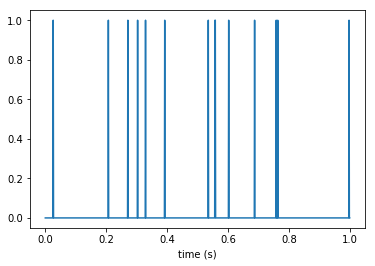

In [19]:
spikes_poisson = homogeneous_poisson(rate, tmax, bin_size)
time = np.arange(len(spikes_poisson)) * bin_size
plt.plot(time, spikes_poisson)
plt.xlabel('time (s)')

Большие всплески на приведенном выше графике соответствуют, ну, всплескам. Поскольку это случайный процесс, каждая реализация будет немного отличаться. Мы можем генерировать множество реализаций или испытаний на языке pythonic, используя генераторы. Генератор похож на функцию, но вместо возврата одного объекта (числа, массива, списка и т.д.) Он может возвращать последовательность таких объектов — по одному за раз. Что отличает генератор от функции, так это то, что он использует yield оператор вместо return:

In [20]:
def homogeneous_poisson_generator(n_trials, rate, tmax, bin_size):
    for i in range(n_trials):
        yield homogeneous_poisson(rate, tmax, bin_size)

Чтобы сгенерировать 1000 проб, мы могли бы просто создать генератор и упаковать его результаты в список:

In [21]:
spike_trains = list(homogeneous_poisson_generator(1000, rate, tmax, bin_size))

Однако для этого потребуется достаточно памяти для хранения всей (возможно длинной) последовательности импульсов. Преимущество генераторов в том, что их можно вычислять лениво, то есть только тогда, когда значение действительно необходимо. Например, чтобы вычислить количество скачков в каждом ряду, мы можем просто просуммировать все значения, используя представление списка:

In [22]:
n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(1000, rate, tmax, bin_size)] 

Обратите внимание, что в этом случае нам не нужно сохранять последовательности всплесков. Мы просто генерируем один, вычисляем количество всплесков, затем отбрасываем его и генерируем другую последовательность. Это также можно сделать более функциональным способом, используя map функция (которая применяет функцию в ее первых аргументах ко всем объектам, возвращаемым генератором):

In [23]:
n_spikes = list(map(np.sum, homogeneous_poisson_generator(1000, rate, tmax, bin_size)))

Функциональный подход и подход к пониманию списка эквивалентны с точки зрения производительности (и удобочитаемости), поэтому, пожалуйста, продолжайте и выберите тот, который вам больше нравится.

Давайте посмотрим на распределение количества всплесков в 1000 случайных реализациях последовательности всплесков:

Text(0,0.5,'number of realisations')

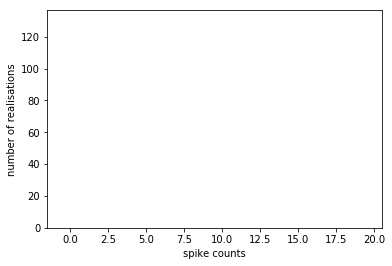

In [26]:
n_spikes = np.array(n_spikes)
bin_edges =  np.arange(n_spikes.max() + 1) - 0.5
plt.hist(n_spikes, bin_edges, fc='none')
plt.xlabel('spike counts')
plt.ylabel('number of realisations')

Таким образом, мы получаем распределение количества событий (пиков) при повторяющихся реализациях пуассоновского процесса с одинаковой скоростью. Обратите внимание, что среднее значение и дисперсия этого распределения равны скорости, умноженной на длину последовательности скачков:

In [28]:
print("Mean: {:.1f}".format(n_spikes.mean()))
print("Variance: {:.1f}".format(n_spikes.var()))
print("Rate * train length: {:.1f}".format(rate * tmax))

Mean: 9.9
Variance: 9.8
Rate * train length: 10.0


Отношение дисперсии к среднему называется коэффициентом Фано, и для распределения Пуассона оно равно 1:

In [29]:
ff = np.var(n_spikes)/np.mean(n_spikes)
print("Fano factor: {:.1f}".format(ff))

Fano factor: 1.0


## Распределение Пуассона

Распределение Пуассона - это распределение вероятностей, которое описывает количество событий, происходящих с определенной частотой за фиксированный интервал времени. Мы уже видели один пример такого распределения на гистограмме выше. Это распределение задается одним параметром λ которая является просто произведением скорости и длины временного интервала. Вероятность наличия k затем spikes присваивается:

$$
P(x = k) = \frac{λk}{k!}e^{-λ}
$$

Обратите внимание, что распределение Пуассона является дискретным распределением вероятностей, что означает, что k может содержать только целочисленные значения. Давайте определим это распределение в функции Python, а затем построим его:

In [30]:
def poisson_prob(k, lam):
    return lam**k/special.factorial(k)*np.exp(-lam)

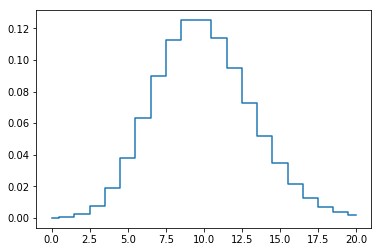

In [31]:
lam = rate * tmax
k = bin_edges + 0.5
prob = poisson_prob(k, lam)
plt.plot(k, prob, drawstyle='steps-mid');

Чтобы подчеркнуть, что распределение Пуассона дискретно, я решил построить его с использованием шагов вместо прямых линий по умолчанию. Теперь мы можем наложить распределение на гистограммы, которые мы получили ранее.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'probability')

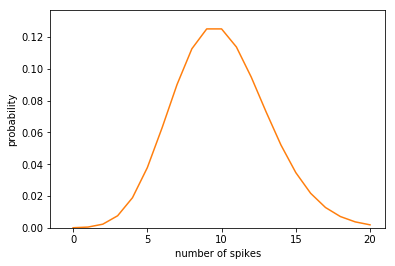

In [32]:
plt.hist(n_spikes, bin_edges, fc='none', normed=True)
plt.plot(k, prob)
plt.xlabel('number of spikes')
plt.ylabel('probability')

Из соображений удобства чтения я изобразил распределение непрерывными линиями вместо шагов.

Для увеличения λ распределение Пуассона приближается к гауссовскому со средним значением и дисперсией, равными λ. Давайте построим распределение для нескольких значений λ:

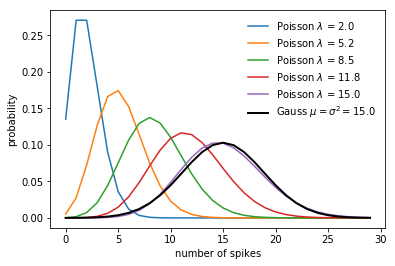

In [33]:
x = np.arange(30)
for lam in np.linspace(2, 15, 5):
    plt.plot(x, poisson_prob(x, lam), label='Poisson $\lambda$ = %.1f' % lam)
def gaussian_pdf(x, mu, sigma_sq):
    return 1/(np.sqrt(2*np.pi*sigma_sq))*np.exp(-(x-mu)**2/sigma_sq/2)
plt.plot(gaussian_pdf(x, lam, lam), 'k', label="Gauss $\mu = \sigma^2=%.1f$" % (lam,), lw=2)
plt.legend(frameon=False)
plt.xlabel('number of spikes')
plt.ylabel('probability');

Для сравнения я также построил гауссову функцию распределения вероятностей с дисперсией и средним значением, равным наибольшему из λs. Мы видим, что распределение Пуассона с этим λ хорошо аппроксимируется методом Гаусса.

## Выборка из распределения Пуассона

Приближение Бернулли работает, только если мы выбираем размер ячейки таким образом, чтобы вероятность всплеска в каждой ячейке была близка к 0 и большинство ячеек содержали не более одного всплеска. Когда размер ячейки достаточно велик, некоторые ячейки могут содержать два или более пиков, которые не могут быть захвачены двоичным распределением Бернулли. Если нас интересует только количество скачков, мы могли бы избежать этой проблемы, сделав выборку непосредственно из распределения Пуассона. stats модуль из scipy пакета реализует генераторы случайных чисел для множества различных дистрибутивов. Например, для генерации выборок из распределения Пуассона мы можем использовать функцию poisson.rvs (rvs означает случайные изменения):

In [34]:
from scipy import stats
lam = 5.
n_spikes = stats.poisson.rvs(lam, size=1000)

Это генерирует 1000 выборок из распределения Пуассона с λ=5:

Text(0.5,0,'samples')

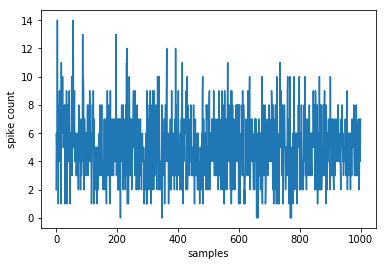

In [35]:
plt.plot(n_spikes);
plt.ylabel('spike count')
plt.xlabel('samples')

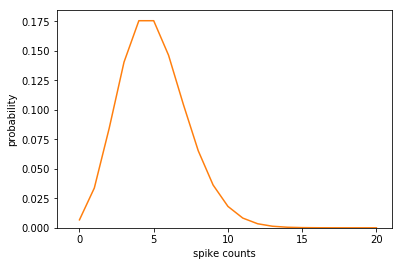

In [36]:
plt.hist(n_spikes, bin_edges, fc='none', normed=True);
plt.plot(k, poisson_prob(k, lam));
plt.xlabel('spike counts')
plt.ylabel('probability');

## Интервалы между вставками

До сих пор мы изучали статистику количества всплесков процесса Пуассона. Другой способ взглянуть на процесс Пуассона - как на набор временных точек, в которые был сгенерирован всплеск (времена всплесков). Мы можем получить времена всплесков из разнесенной последовательности, сгенерированной с использованием приближения Бернулли, просто найдя все единицы в последовательности. nonzero функция numpy возвращает индексы всех ненулевых элементов массива, переданных в ее аргументе:

In [37]:
spt,= np.nonzero(spikes_poisson)
print("Indices of first 5 spikes:", spt[:5])

('Indices of first 5 spikes:', array([ 26, 207, 271, 303, 329]))


Чтобы преобразовать индексы во времена всплесков, нам просто нужно умножить их на размер ячейки. Распространенный способ визуализации времен всплесков - использовать растровые графики. На растровом графике ось времени представлена абсциссой, а каждый пик обозначен одним маркером, таким как маленькая галочка, точка или звезда. Для создания растрового графика мы будем использовать vlines функция matplotlib, которая выводит вертикальные линии в местах, указанных в ее первом аргументе:

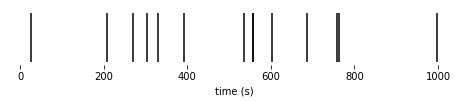

In [38]:
def raster_plot(spt):
    plt.figure(figsize=(8,1))
    plt.subplot(frameon=False)
    plt.vlines(spt, 0, 1)
    plt.xlabel('time (s)')
    plt.yticks([])
    
raster_plot(spt)

Интервалы между скачками могут быть рассчитаны с помощью numpy diff функция, которая вычисляет различия между последовательными значениями в массиве:

Text(0.5,0,'interval index')

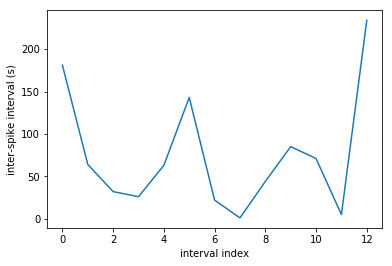

In [39]:
isi = np.diff(spt)
plt.plot(isi)
plt.ylabel("inter-spike interval (s)")
plt.xlabel("interval index")

Позже мы будем повторно использовать этот код, поэтому давайте определим функцию, которая вычисляет интервалы между всплесками на основе разбитой последовательности всплесков:

In [40]:
def calc_isi(binary_train, bin_size):
    spt,= np.nonzero(spikes_poisson)
    spt = spt * bin_size
    isi = np.diff(spt)
    return isi

Теперь мы можем построить гистограмму интервалов между скачками:

Text(0,0.5,'probability density (1/s)')

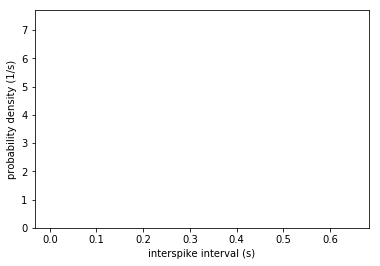

In [47]:
spikes_poisson = homogeneous_poisson(rate, 100 * s, bin_size)
isi = calc_isi(spikes_poisson, bin_size)
isi_bins = np.linspace(0, isi.max(), 10)
plt.hist(isi, isi_bins, fc='none', normed=True)
plt.xlabel("interspike interval (s)")
plt.ylabel("probability density (1/s)")

Интервалы между всплесками точечного процесса Пуассона распределены в соответствии с экспоненциальным распределением. В отличие от дискретного распределения Пуассона экспоненциальное распределение представляет собой непрерывное распределение вероятностей, функция плотности вероятности которого (pdf) задается:

$$
p(x)=λ * exp(−λx)
$$

где λ параметр равен скорости стрельбы.

Мы можем наложить теоретический PDF-файл на гистограмму, чтобы проверить их сходство:

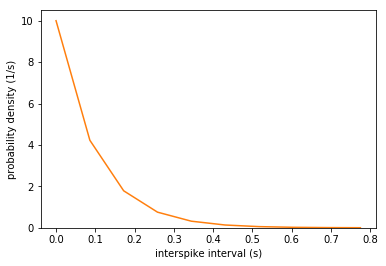

In [45]:
plt.hist(isi, isi_bins, fc='none', normed=True);
def expn_pdf(x, lam):
    return lam*np.exp(-lam*x)
plt.plot(isi_bins, expn_pdf(isi_bins, rate))
plt.xlabel("interspike interval (s)")
plt.ylabel("probability density (1/s)");

Стандартное отклонение и среднее значение интервалов между скачками распределения Пуассона равны. Следовательно, отношение между стандартным отклонением и средним, называемое коэффициентом вариации (CV), равно 1. На практике резюме часто используется для характеристики "случайности" спайк-шлейфа:

In [48]:
cv = np.std(isi)/np.mean(isi) # coefficient of variation
print("Coefficient of variation:", cv)

('Coefficient of variation:', 1.0073899099608936)


Мы можем использовать тот факт, что нам известно распределение интервалов между всплесками, для генерации времени всплесков Пуассона. Сначала мы вычерчиваем случайные интервалы между всплесками из экспоненциального распределения. С этой целью мы будем использовать expon.rvs функции scipy.stats модуль:

In [49]:
def generate_isi(rate, n_spikes):
    isi = stats.expon.rvs(scale=1./rate, size=n_spikes)
    return isi

n_spikes = 1000
isi = generate_isi(rate, n_spikes)

Теперь нам просто нужно просуммировать интервалы между всплесками, чтобы получить время всплесков. Для вычисления совокупной суммы интервалов мы можем использовать cumsum функцию numpy. Мы проверяем точность сгенерированной последовательности скачков, оценивая частоту скачков и сравнивая ее с целевой частотой:

In [50]:
# generation of poisson spikes by means of ISI
spike_train = np.cumsum(isi)
print("Rate: %.1f Hz" % (len(spike_train)/spike_train.max(), ))
print("Target rate: %.1f Hz" % (rate, ))

Rate: 9.6 Hz
Target rate: 10.0 Hz


С помощью этого метода мы получаем непосредственно времена всплесков, которые мы можем визуализировать с помощью растрового графика, как и раньше:

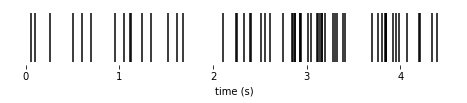

In [51]:
raster_plot(spike_train[:60])

Наконец, мы можем проверить, действительно ли время всплесков, сгенерированное таким образом, соответствует распределению Пуассона. Для этого нам нужно записать в бин последовательность всплесков, то есть считать всплески за фиксированные промежутки времени. Мы можем определить функцию, которая принимает время всплеска и размер ячейки в качестве аргумента и возвращает массив значений:

In [52]:
def count_spikes(spike_train, bin_size):
    bins = np.arange(0, spike_train[-1], bin_size)
    cumulated_counts = np.searchsorted(spike_train, bins)
    counts = np.diff(cumulated_counts)
    return counts

Комментарии:

- L2: Сначала мы определяем массив ребер ячеек.
- L3: Мы находим индексы пиков, которые следуют непосредственно за каждым краем ячейки, используя функцию numpy.searchsorted .
- L4: Различия индексов соответствуют количеству шипов между краями.

## Рефрактерный период

Процесс Пуассона не является реалистичным представлением статистики скачков в мозге. Одним из биологически неправдоподобных свойств является то, что интервалы между скачками могут быть произвольно короткими (см. Распределение интервалов между скачками выше). Реальные нейроны после генерации импульса остаются невосприимчивыми в течение некоторого времени, называемого рефрактерным периодом, в течение которого ионные каналы и мембранный потенциал восстанавливаются до состояния покоя. Мы можем имитировать рефрактерный период в пуассоновском процессе, добавляя этот период ко всем сгенерированным интервалам между всплесками:

In [53]:
rate = 100 * Hz
refractory_period = 8 * ms

isi = generate_isi(rate, 5000)
isi_ref = isi + refractory_period

Теперь мы можем сравнить статистику (скорость срабатывания и минимальный интервал между всплесками) пуассоновского процесса и того же процесса с рефрактерным периодом:

In [72]:
def estimate_rate_from_isi(isi):
    return len(isi)/np.sum(isi)

print("Refractory period:", refractory_period / ms, 'ms')
print("Minimum inter-spike interval:")
print(" - Poisson process: {:.1f} ms".format(float(isi.min())))
print(" - Poisson with ref. period: {:.1f} ms".format(isi_ref.min()/ms))
print('Firing rate:')
print(" - Poisson process: {:.1f} Hz".format(estimate_rate_from_isi(isi)))
print(" - Poisson with ref. period: {:.1f} Hz".format(estimate_rate_from_isi(isi_ref)))

('Refractory period:', 8.0, 'ms')
Minimum inter-spike interval:
 - Poisson process: 0.0 ms
 - Poisson with ref. period: 8.0 ms
Firing rate:
 - Poisson process: 102.1 Hz
 - Poisson with ref. period: 56.2 Hz


Обратите внимание, что, удлинив интервалы между шипами, мы также уменьшили полученную скорость срабатывания. Новую скорость срабатывания можно рассчитать по уравнению:
$$
ν_{ref}=(λ^−1+τ_{ref})^{−1}
$$

Чтобы компенсировать снижение, нам необходимо увеличить λ параметр экспоненциального распределения, из которого мы вычерчиваем интервалы. Если мы решим приведенное выше уравнение для λ мы получаем правильный параметр:

$$
\begin{equation}
λ=(
\begin{aligned}
    \text{ν−1} \\
    \text{ref}
\end{aligned}
−τ_{ref})^{−1}
\end{equation}
$$

Теперь мы реализуем эту коррекцию в функции, генерирующей интервалы между всплесками с рефрактерным периодом:

In [82]:
def generate_isi_refractory(rate, tau_ref, n_spikes):
    lam = 1 / (1 / rate - tau_ref)
    if lam <= 0:
        isi = np.zeros(n_spikes)
    else:
        scale = 1. / lam if lam > 0 else 1e6  # Set a large scale when lam is negative
        isi = stats.expon.rvs(scale=scale, size=n_spikes)
        isi = isi + tau_ref
    return isi

Мы можем проверить, правильны ли после этого изменения ожидаемая частота срабатывания и интервалы между импульсами:

In [83]:
isi_ref = generate_isi_refractory(rate, refractory_period, 1000)
print("Minimum inter-spike interval: {:.1f} ms".format(isi_ref.min() / ms))
print('Firing rate: {:.1f} Hz'.format(estimate_rate_from_isi(isi_ref)))

Minimum inter-spike interval: 0.0 ms
Firing rate: inf Hz


/Users/darius/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:150: RuntimeWarning: divide by zero encountered in double_scalars


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/histograms.py:903: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


TypeError: xlabel() takes at least 1 argument (0 given)

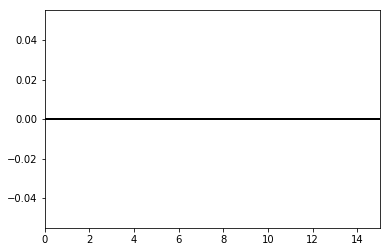

In [84]:
#introducing refractory period
count_interval = 50  
msn_spikes = 5000

isi_ref = generate_isi_refractory(rate, refractory_period, n_spikes)
spike_train_ref = np.cumsum(isi_ref)
counts_ref = count_spikes(spike_train_ref, count_interval)

plt.hist(counts_ref, bin_edges, fc='red', normed=True, label='with refractoriness')
plt.plot(k, poisson_prob(k, rate * count_interval), 'k', lw=2, label='Poisson distribution')
plt.xlim(0, 15)
plt.xlabel( )
plt.ylabel('probability')
plt.legend(frameon=False);

Распределение количества спайков в последовательности спайков с рефрактерным периодом (красные столбики) отличается от распределения Пуассона (черная линия). Это также отражается на значении коэффициента вариации:

In [85]:
def calc_cv(isi):
    return np.std(isi)/np.mean(isi)
print("CV with refractoriness: {:.1f}".format(calc_cv(isi_ref)))

CV with refractoriness: nan


/Users/darius/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Обратите внимание, что это значение намного ниже, чем CV распределения Пуассона (равное 1), что является признаком того, что процесс с рефрактерным периодом на самом деле более регулярный. Это также непосредственно видно на растровом графике:

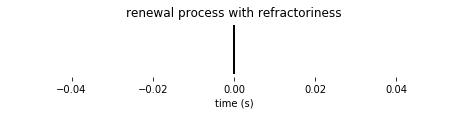

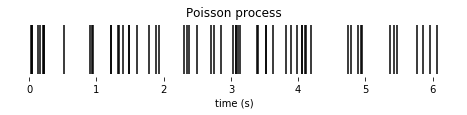

In [86]:
raster_plot(spike_train_ref[:60])
plt.title('renewal process with refractoriness');
raster_plot(spike_train[:60])
plt.title('Poisson process');

## Неоднородный процесс Пуассона
До сих пор мы рассматривали только однородный процесс Пуассона, то есть процесс, в котором скорость постоянна и не меняется во времени. Однако в нервной системе информация о внешних стимулах кодируется во временных вариациях активности нейронов. В первом приближении мы можем рассмотреть случай, когда изменяется скорость стрельбы, что приводит к возникновению неоднородного пуассоновского процесса. Чтобы представить ее, мы просто заменяем постоянную скорость стрельбы массивом скоростей стрельбы, по одному значению на ячейку. Например, мы можем сгенерировать частоту стрельбы, изменяющуюся с частотой 1 Гц:

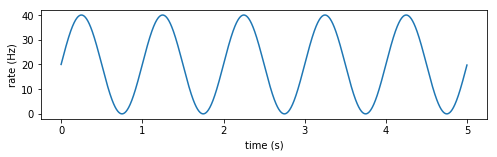

In [87]:
tmax = 5*s
max_rate = 40 * Hz
f_osc = 1 * Hz
bin_size = 2 * ms
time = np.arange(0, tmax, bin_size)
rate = max_rate * (np.sin(2*np.pi*f_osc*time)+1)/2

plt.figure(figsize=(8, 2))
plt.plot(time, rate)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

Для генерации последовательностей скачков мы можем снова использовать приближение Бернулли. Единственное изменение заключается в том, что мы заменяем значение скорости массивом и сравниваем каждое случайное число с последовательными элементами массива. Операторы сравнения, определенные в numpy, работают прозрачно как для отдельных значений, так и для массивов, поэтому нам не нужно изменять код. Мы можем пропустить tmax аргумент функции (продолжительность поезда), потому что его можно получить непосредственно из длины массива rate. Кроме того, мы также определяем генератор Python для генерации нескольких пробных версий spike train:

In [94]:
def inhomogeneous_poisson(rate, bin_size):
    n_bins = len(rate)
    spikes = np.random.rand(n_bins) < rate * bin_size
    spike_times = np.nonzero(spikes)[0] * bin_size
    
    return spike_times

def inhomogeneous_poisson_generator(n_trials,rate,bin_size):
    for i in range(n_trials):
        yield inhomogeneous_poisson(rate,bin_size)

Мы также расширили растровый график, чтобы показать несколько испытаний составов spike, наложенных друг на друга.

In [92]:
def raster_plot_multi(spike_times):
    for i, spt in enumerate(spike_times):
        plt.vlines(spt, i, i+1)
    plt.yticks([])

Давайте смоделируем 100 испытаний с частотой колебаний, как показано выше, и отобразим их в виде растра.

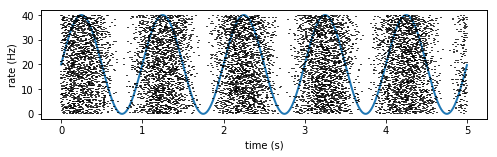

In [97]:
n_trials = 100

plt.figure(figsize=(8,2))
plt.plot(time, rate, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
spike_times = list(inhomogeneous_poisson_generator(n_trials, rate, bin_size))
plt.twinx()
raster_plot_multi(spike_times=spike_times)

На растровом графике вы можете видеть, как пиковые значения модулируются во времени. Плотность пиковых значений соответствует скорости, зависящей от времени, наложенной на график (синий).

Наконец, мы можем рассчитать коэффициент вариации для одного из испытаний:

In [98]:
isi = np.diff(spike_times[0])
print("CV – inhomogeneous Poisson: %.1f" % calc_cv(isi))

CV – inhomogeneous Poisson: 1.9


CV неоднородного пуассоновского процесса больше 1, что указывает на то, что он более нерегулярен, чем однородный экземпляр.

Подводя итог:

- CV = 1 - регулярность последовательности скачков, равная регулярности процесса Пуассона,
- CV < 1 - более регулярный, чем процесс Пуассона (например, из-за тугоплавкости),
- CV > 1 - менее регулярный, чем процесс Пуассона (например, из-за различий в скорости стрельбы или очередности).